In [1]:
import jax
jax.config.update("jax_compilation_cache_dir", "./jax-cache")
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update('jax_platforms', 'cpu')
import numpy as np
import functools

In [2]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
import itertools

In [3]:
import matplotlib.pyplot as plt
import sys 
sys.path.append('../plot_helpers/')
from plot_helper_for_paper import set_size, plot_imshow, plot_contourf

In [4]:
sys.path.append('../fft_helpers/')

from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor
from custom_solvers import conjugate_gradient

## constructing an RVE

In [5]:
import random

random.seed(1)

def place_circle(matrix, n, r, x_center, y_center):
    for i in range(n):
        for j in range(n):
            if (i - x_center)**2 + (j - y_center)**2 <= r**2:
                matrix[i][j] = 1

def generate_matrix_with_circles(n, x, r):
    if r >= n:
        raise ValueError("Radius r must be less than the size of the matrix n")
        
    matrix = np.zeros((n, n), dtype=int)
    placed_circles = 0
    
    while placed_circles < x:
        x_center = random.randint(0, n-1)
        y_center = random.randint(0, n-1)
        
        # Check if the circle fits within the matrix bounds
        if x_center + r < n and y_center + r < n and x_center - r >= 0 and y_center - r >= 0:
            previous_matrix = matrix.copy()
            place_circle(matrix, n, r, x_center, y_center)
            if not np.array_equal(previous_matrix, matrix):
                placed_circles += 1

    return matrix

# Example usage
n = 199
x = 10
r = 20
structure = generate_matrix_with_circles(n, x, r)

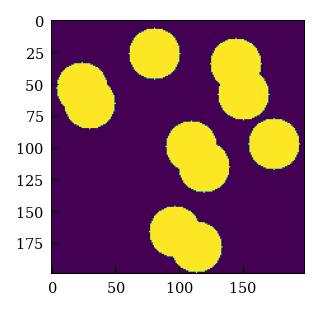

In [6]:
plt.imshow(structure)

In [7]:
ndim = len(structure.shape)
N = structure.shape[0]

# grid dimensions
shape = [
    N,
] * ndim  # number of voxels in all directions

We also define certain Identity tensor for each grid point.

- $\mathbf{I}$ = 2 order Identity tensor with shape `(2, 2, N, N)` 
- $\mathbb{I4}$ = 4 order Identity tensor with shape `(2, 2, 2, 2, N, N)`


## fft helpers and operators

In [8]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 2nd order Identity tensor
I4 = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("il,jk", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 4th order Identity tensor
I4rt = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("ik,jl", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4s = (I4 + I4rt) / 2.0

II = tensor.dyad22(I, I)
I4d = I4s - II / 3.0

In [9]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))


@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

The projection operator

In [10]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="fourier", length=1.0)

## assigning material parameters 
We assign material parameters to the two phases. The two phases within the RVE are denoted as
- Soft
- Hard

In [11]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=["soft", "hard"])
def param(X, soft, hard):
    return hard * jnp.ones_like(X) * (X) + soft * jnp.ones_like(X) * (1 - X)

We consider a `linear isotropic hardening law` for both the phases

In [12]:
# material parameters
K = param(structure, soft=0.833, hard=2*0.833)  # bulk      modulus
μ = param(structure, soft=0.386, hard=2*0.386)  # shear     modulus
H = param(
    structure, soft=2000.0e6 / 200.0e9, hard=2.0 * 2000.0e6 / 200.0e9
)  # hardening modulus
sigma_y = param(
    structure, soft=600.0e6 / 200.0e9, hard=2.0 * 600.0e6 / 200.0e9
)  # initial yield stress
n = 1. # param(
   # structure, soft=1., hard=1.
#)

## plasticity basics

Now we define the basics of plasticity implementation:
- yield surface
  $$\Phi(\sigma_{ij}, \varepsilon^p_{ij}) = \underbrace{\sqrt{\dfrac{3}{2}\sigma^{dev}_{ij}\sigma^{dev}_{jk}}}_{\sigma^{eq}} - (\sigma_{0} + H\varepsilon^{p})$$
- return mappping algorithm
  $$\delta \varepsilon =  \dfrac{\langle \Phi(\sigma_{ij}, \varepsilon_{p}) \rangle_{+}}{3\mu + H}$$
- tangent stiffness operator

In [13]:
@jax.jit
def yield_function(ep):
    return sigma_y + H*ep**n

In [14]:
@jax.jit
def constitutive(eps, eps_t, epse_t, ep_t):

    # elastic stiffness tensor
    C4e = K * II + 2.0 * μ * I4d

    # trial state
    epse_s = epse_t + (eps - eps_t)
    sig_s = tensor.ddot42(C4e, epse_s)
    sigm_s = tensor.ddot22(sig_s, I) / 3.0
    sigd_s = sig_s - sigm_s * I
    sigeq_s = jnp.sqrt(3.0 / 2.0 * tensor.ddot22(sigd_s, sigd_s))

    # avoid zero division below ("phi_s" is corrected below)
    Z = jnp.where(sigeq_s == 0, True, False)
    sigeq_s = jnp.where(Z == True, 1, sigeq_s)

    # evaluate yield surface, set to zero if elastic (or stress-free)
    sigy = yield_function(ep_t)
    phi_s = sigeq_s - sigy
    phi_s = 1.0 / 2.0 * (phi_s + jnp.abs(phi_s))
    phi_s = jnp.where(Z == True, 0.0, phi_s)
    elastic_pt = jnp.where(phi_s <= 0, True, False)

    # plastic multiplier, based on non-linear hardening
    # - initialize
    dep = phi_s / (3 * μ + H)

    # return map algorithm
    N = 3.0 / 2.0 * sigd_s / sigeq_s
    ep = ep_t + dep
    sig = sig_s - dep * N * 2.0 * μ
    epse = epse_s - dep * N

    # plastic tangent stiffness
    C4ep = (
        C4e
        - 6.0 * (μ**2.0) * dep / sigeq_s * I4d
        + 4.0 * (μ**2.0) * (dep / sigeq_s - 1.0 / (3.0 * μ + H)) * tensor.dyad22(N, N)
    )

    # consistent tangent operator: elastic/plastic switch
    elastic_pt = elastic_pt.astype(jnp.float64)
    K4 = C4e * elastic_pt + C4ep * (1.0 - elastic_pt)

    # return 3-D stress, 2-D stress/tangent, and history
    return sig, K4, epse, ep

In [15]:
# functions for the projection 'G', and the product 'G : K : eps'
@jax.jit
def G(A2):
    return jnp.real(ifft(tensor.ddot42(Ghat4_2, fft(A2)))).reshape(-1)


@jax.jit
def K_deps(depsm, K4):
    return tensor.ddot42(K4, depsm.reshape(ndim, ndim, N, N))


@jax.jit
def G_K_deps(depsm, K4):
    return G(K_deps(depsm, K4))

In [16]:
@jax.jit
def solve_plasticity(state, n):
    deps, b, eps, eps_t, epse_t, ep_t, Fn, K4, sig = state

    error = jnp.linalg.norm(deps) / Fn
    jax.debug.print("residual={}", error)

    def true_fun(state):
        deps, b, eps, eps_t, epse_t, ep_t, Fn, K4, sig = state

        deps, iiter = conjugate_gradient(
            atol=1e-6,
            A=G_K_deps,
            b=b,
            additional=K4,
        )  # solve linear system using CG

        jax.debug.print('CG iteration {}', iiter)

        deps = deps.reshape(ndim, ndim, N, N)
        eps = jax.lax.add(eps, deps)  # update DOFs (array -> tensor.grid)
        sig, K4, epse, ep = constitutive(
            eps, eps_t, epse_t, ep_t
        )  # new residual stress
        b = -G(sig)  # compute residual

        return (deps, b, eps, eps_t, epse, ep, Fn, K4, sig)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-5, true_fun, false_fun, state), n

In [17]:
# initialize: stress and strain tensor, and history
eps = jnp.zeros([ndim, ndim, N, N], dtype="float64")
eps_t = jnp.zeros([ndim, ndim, N, N], dtype="float64")
epse_t = jnp.zeros([ndim, ndim, N, N], dtype="float64")
ep_t = jnp.zeros([N, N], dtype="float64")
sig = jnp.zeros([ndim, ndim, N, N], dtype="float64")


# initial tangent operator: the elastic tangent
K4 = K * II + 2.0 * μ * I4d

# define incremental macroscopic strain
ninc = 100
epsbar = 0.12
DE = jnp.zeros([ndim, ndim, N, N], dtype="float64")
DE = DE.at[0, 0].set(jnp.sqrt(3.0) / 2.0 * epsbar / float(ninc))
DE = DE.at[1, 1].set(-jnp.sqrt(3.0) / 2.0 * epsbar / float(ninc))


b = -G_K_deps(DE, K4)
eps = jax.lax.add(eps, DE)
En = jnp.linalg.norm(eps)

In [18]:
state = (DE, b, eps, eps_t, epse_t, ep_t, En, K4, sig)
state = jax.device_put(state)

In [19]:
import timeit

In [25]:
start_time = timeit.default_timer()

final_state, xs = jax.lax.scan(solve_plasticity, init=state, xs=jnp.arange(0, 10))

final_time = timeit.default_timer()
print(final_time-start_time)

residual=1.0
CG iteration 13
residual=0.3045565744948102
CG iteration 0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
0.1283025862649083


In [23]:
np.savetxt('./additional_data/normal_plastic_strain.txt', final_state[5])
np.savetxt('./additional_data/normal_strain.txt', final_state[2].at[1, 1].get())

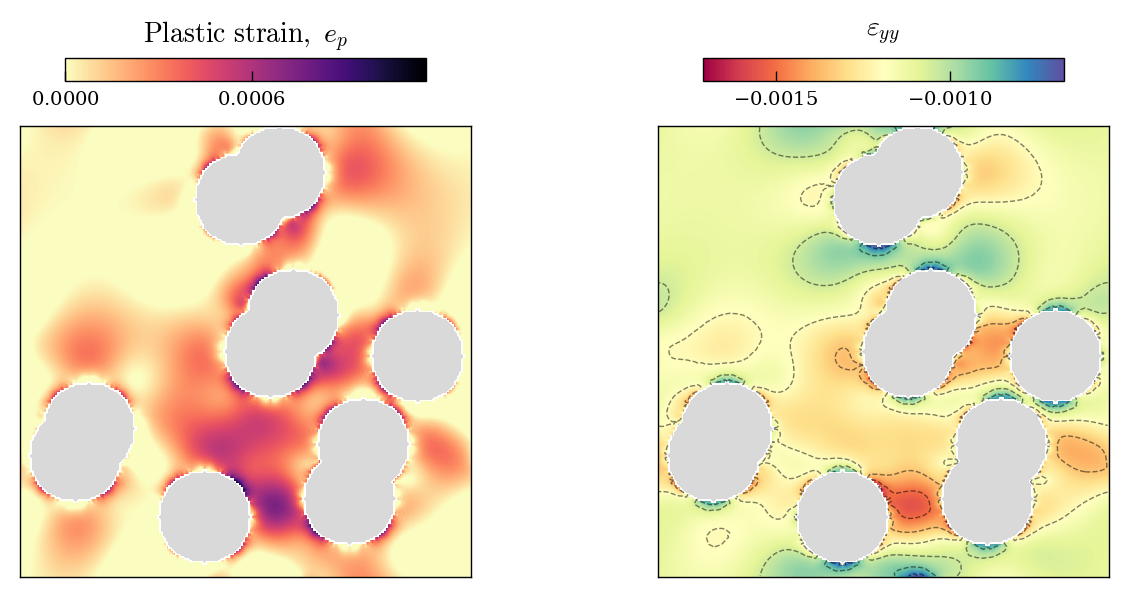

In [21]:
fig = plt.figure(figsize=set_size(width='two-column', fraction=0.9, height_ratio=0.45), constrained_layout=True, dpi=200)
gs1 = fig.add_gridspec(1, 2, wspace=0.001, hspace=0.001)

ax = fig.add_subplot(gs1[0, 0])

ax.contourf(np.ma.array(structure[:, :], mask=1-structure), alpha=1,  cmap='Greys', zorder=30)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(final_state[5], mask=structure),
            title=r'$\mathrm{Plastic~strain,}~e_p$', cmap='magma_r')

ax.set_aspect(1/ax.get_data_ratio())

ax = fig.add_subplot(gs1[0, 1])

ax.contourf(np.ma.array(structure[:, :], mask=1-structure), alpha=1,  cmap='Greys', zorder=30)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(final_state[2].at[1, 1].get(), mask=structure),
            title=r'$\varepsilon_{yy}$', cmap='Spectral')
ax.contour(np.ma.array(final_state[2].at[1, 1].get(), mask=structure), alpha=0.5,  colors='black', zorder=30, linewidths=0.5)
plt.show()